In [1]:
import os
import tarfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import time
import re
import io
from tqdm import tqdm    # tqdm
import random

print(tf.__version__)

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)
# '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

2.6.0


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
os.getcwd()

'/aiffel/aiffel/s2s_translation'

In [3]:
# train
data_path = "/aiffel/aiffel/s2s_translation/data"
file_name = "korean-english-park.train.tar.gz"
file_path = os.path.join(data_path, file_name)

if tarfile.is_tarfile(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=data_path)
        print(f"압축 해제 : {file_name}")
else:
    print(f"'{file_name}'압축 해제 실패")

압축 해제 : korean-english-park.train.tar.gz


In [4]:
# test
data_path = "/aiffel/aiffel/s2s_translation/data"
file_name = "korean-english-park.test.tar.gz"
file_path = os.path.join(data_path, file_name)

if tarfile.is_tarfile(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=data_path)
        print(f"압축 해제 : {file_name}")
else:
    print(f"'{file_name}'압축 해제 실패")

압축 해제 : korean-english-park.test.tar.gz


In [5]:
# korean-english-park.test.en
# korean-english-park.test.ko
# korean-english-park.train.en
# korean-english-park.train.ko
train_ko_path = os.path.join(data_path, "korean-english-park.train.ko")
train_en_path = os.path.join(data_path, "korean-english-park.train.en")
test_ko_path = os.path.join(data_path, "korean-english-park.test.ko")
test_en_path = os.path.join(data_path, "korean-english-park.test.en")

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

train_ko = load_file(train_ko_path)
train_en = load_file(train_en_path)
test_ko = load_file(test_ko_path)
test_en = load_file(test_en_path)

In [6]:
print("train_ko length :", len(train_ko))
print("train_en length:", len(train_en))
print("test_ko length:", len(test_ko))
print("test_en length:", len(test_en))

train_ko length : 94123
train_en length: 94123
test_ko length: 2000
test_en length: 2000


In [7]:
2000/(94123+2000)

0.02080667478126983

In [12]:
# 병렬쌍이 흐트러지지 않게 묶어버리기 
train_pairs = list(zip(train_ko, train_en))

# 병렬쌍 (한영 전부 같은 것들) 중복 제거
train_pairs = list(set(train_pairs))

# 다시 분리
train_ko, train_en = zip(*train_pairs)

# 리스트화 
train_ko = list(train_ko)
train_en = list(train_en)

print(f"train_ko length: {len(train_ko)}")
print(f"train_en length: {len(train_en)}")

train_ko length: 78968
train_en length: 78968


In [13]:
test_pairs = list(zip(test_ko, test_en))

test_pairs = list(set(test_pairs))

test_ko, test_en = zip(*test_pairs)

test_ko = list(test_ko)
test_en = list(test_en)

print(f"train_ko length: {len(test_ko)}")
print(f"train_en length: {len(test_en)}")

train_ko length: 1996
train_en length: 1996


### 전처리

In [16]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)  # 한글과 영어 외 제거

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence

In [17]:
train_ko = [preprocess_sentence(sent) for sent in train_ko]
train_en = [preprocess_sentence(sent, s_token=True, e_token=True) for sent in train_en]
test_ko = [preprocess_sentence(sent) for sent in test_ko]
test_en = [preprocess_sentence(sent, s_token=True, e_token=True) for sent in test_en]

print("train_ko :", train_ko[:3])
print("train_en :", train_en[:3])
print("test_ko :", test_ko[:3])
print("test_en :", test_en[:3])

train_ko : ['영국 대표팀은 오는 월 일 에스토니아와 유로 예선전을 치르며 대표팀 일부 선수들은 베컴의 복귀를 희망하고 있는 것으로 알려졌다 .', 'resumption 회수 , 회복 , 재개', '대부분의 한국인은 지난 년만에 생활 수준이 최저 수준으로 하락했으며 현재의 경제 상황은 년부터 년까지의 외환 위기 이후 년만에 최악인 것으로 여기고 있다고 한국은행이 보고했다 .']
train_en : ['<start> england have a vital euro qualifier in estonia on june and several players have openly called for beckham s return in a bid to revive their dismal campaign . <end>', '<start> security council adopted a resolution , condemning pyongyang s missile launches . <end>', '<start> additionally , many of them regard the current economic conditions as the worst in six years since the financial crisis , the bank of korea bok reported wednesday . <end>']
test_ko : ['이번 공연은 미국 최초의 북한 방문 공연으로써 , 양국간의 긴장된 관계의 돌파구로 간주되고 있다 .', 'pope benedict will make a pilgrimage to the holy land in may 베네딕토 교황 , 월에 성지순례에 나설 예정 .', '로블스는 루 시앙 는 쉽지 않은 상대가 될 것 이라며 그는 좋은 사람이고 중국인들도 그를 사랑한다 고 덧붙였다 .']
test_en : ['<start> this is the first us cultural visit to north korea , and it is bei

### 길이 cutting 문제

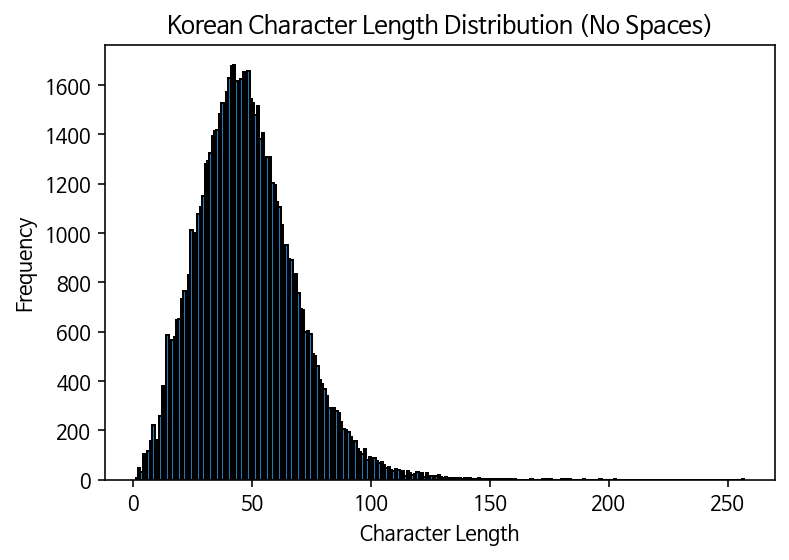

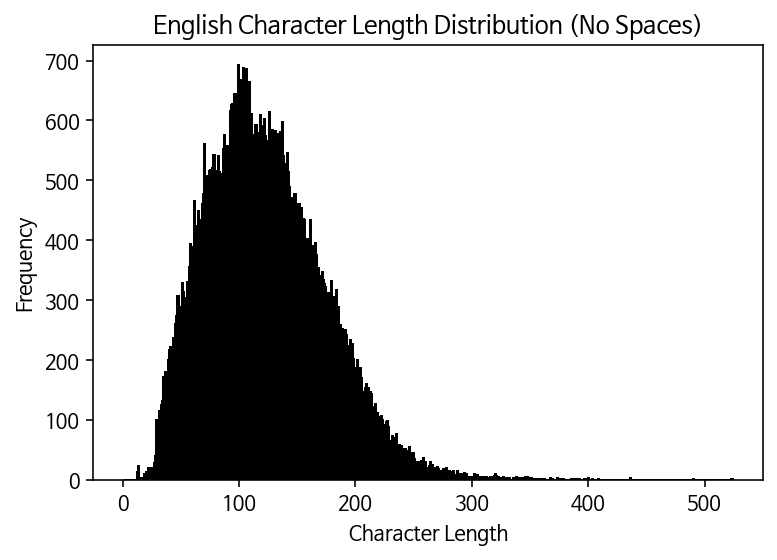

In [18]:
# 한국어 데이터 공백 제외한 글자 길이 분포
char_lengths_ko = [len(sentence.replace(" ", "")) for sentence in train_ko]

# 영어 데이터 공백 제외한 글자 길이 분포
char_lengths_en = [len(sentence.replace(" ", "")) for sentence in train_en]

plt.hist(char_lengths_ko, bins=range(1, max(char_lengths_ko) + 1), edgecolor='black')
plt.title("Korean Character Length Distribution (No Spaces)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(char_lengths_en, bins=range(1, max(char_lengths_en) + 1), edgecolor='black')
plt.title("English Character Length Distribution (No Spaces)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

### 생각해보면 한글이랑 영어를 같은 기준에 두고 글자 단위로 셀 순 없다. 
* 단어 기준으로 한글은 5글자를 넘어가는게 별로 없으나 영어는 무수히 많으니까

In [19]:
# 한국어(train_ko)와 영어(train_en) 데이터 필터링
# 공백 제외 단어 글자 길이 기준 
filtered_train_ko = []
filtered_train_en = []

for ko_sent, en_sent in zip(train_ko, train_en):
    if len(ko_sent.replace(" ", "")) <= 80 and len(en_sent.replace(" ", "")) <= 190:  # 공백 제외 글자 길이 기준
        filtered_train_ko.append(ko_sent)
        filtered_train_en.append(en_sent)

train_ko = filtered_train_ko
train_en = filtered_train_en

print(f"Filtered Korean Sentences: {len(train_ko)}")
print(f"Filtered English Sentences: {len(train_en)}")

Filtered Korean Sentences: 68795
Filtered English Sentences: 68795


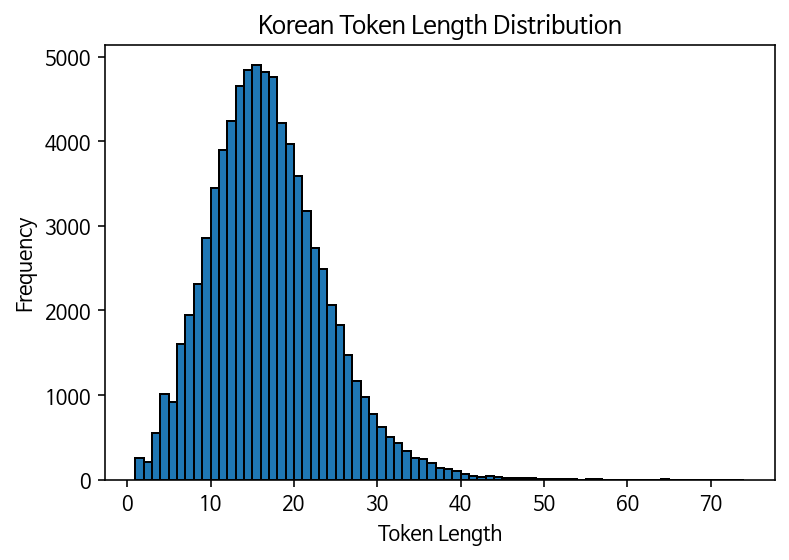

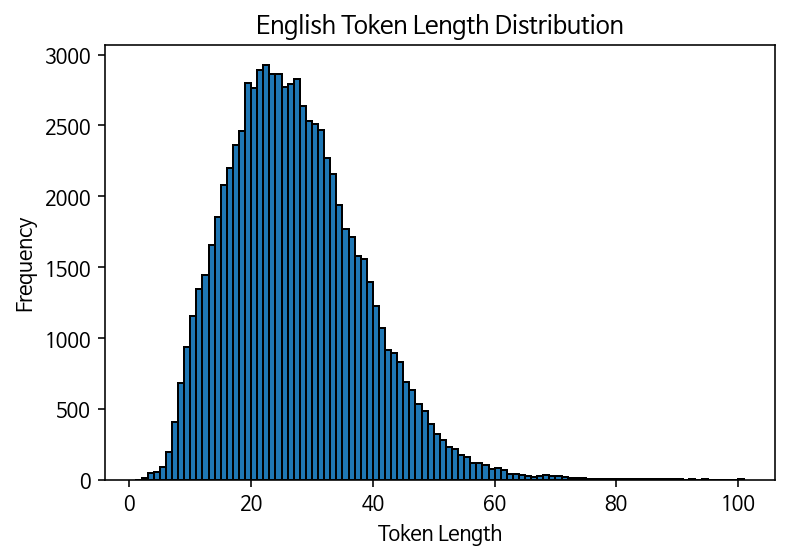

In [57]:
# # 한국어 데이터 토큰 당 길이 분포
# token_lengths_ko = [len(sentence.split()) for sentence in train_ko]

# # 영어 데이터 토큰 당 길이 분포
# token_lengths_en = [len(sentence.split()) for sentence in train_en]

# # 한국어 데이터 토큰 길이 분포 히스토그램
# plt.hist(token_lengths_ko, bins=range(1, max(token_lengths_ko) + 1), edgecolor='black')
# plt.title("Korean Token Length Distribution")
# plt.xlabel("Token Length")
# plt.ylabel("Frequency")
# plt.show()

# # 영어 데이터 토큰 길이 분포 히스토그램
# plt.hist(token_lengths_en, bins=range(1, max(token_lengths_en) + 1), edgecolor='black')
# plt.title("English Token Length Distribution")
# plt.xlabel("Token Length")
# plt.ylabel("Frequency")
# plt.show()

In [59]:
# # train_ko 공백 기준 토큰 길이 필터링
# filtered_train_ko = []

# for ko_sent in train_ko:
#     if len(ko_sent.split()) <= 40:
#         filtered_train_ko.append(ko_sent)

# train_ko = filtered_train_ko

# print(f"Filtered Korean Sentences: {len(train_ko)}")

Filtered Korean Sentences: 78698


### 토큰화

In [18]:
# 공백으로 나눈 한국어
train_ko_words = " ".join(train_ko).split()

# 고유 단어 집합 생성
train_ko_unique_count = set(train_ko_words)

# 고유 단어 개수 출력
len(train_ko_unique_count)

196049

In [19]:
# 공백으로 나눈 영어
train_en_words = " ".join(train_en).split()

# 고유 단어 집합 생성
train_en_unique_count = set(train_en_words)

# 고유 단어 개수 출력
len(train_en_unique_count)

44565

In [20]:
from konlpy.tag import Mecab
from tqdm import tqdm

mecab = Mecab()

# 토큰화
kor_corpus = [" ".join(mecab.morphs(sentence)) for sentence in tqdm(train_ko, desc="Tokenizing train_ko")]

# 결과 확인 (예시로 처음 몇 개 출력)
print("Train KO Tokenized Example:", kor_corpus[:3])

Tokenizing train_ko: 100%|██████████| 68795/68795 [00:09<00:00, 7320.86it/s]

Train KO Tokenized Example: ['영국 대표 팀 은 오 는 월 일 에스 토니아 와 유로 예선전 을 치르 며 대표 팀 일부 선수 들 은 베컴 의 복귀 를 희망 하 고 있 는 것 으로 알려졌 다 .', 'resumption 회수 , 회복 , 재개', '대부분 의 한국인 은 지난 년 만 에 생활 수준 이 최저 수준 으로 하락 했으며 현재 의 경제 상황 은 년 부터 년 까지 의 외환 위기 이후 년 만 에 최악 인 것 으로 여기 고 있 다고 한국은행 이 보 고 했 다 .']


In [21]:
# 영어 데이터 공백 기준 토큰화
eng_corpus = [" ".join(sentence.split()) for sentence in tqdm(train_en, desc="Tokenizing train_en")]

# 결과 확인 (예시로 처음 몇 개 출력)
print("Train EN Tokenized Example:", eng_corpus[:3])

Tokenizing train_en: 100%|██████████| 68795/68795 [00:00<00:00, 475537.54it/s]

Train EN Tokenized Example: ['<start> england have a vital euro qualifier in estonia on june and several players have openly called for beckham s return in a bid to revive their dismal campaign . <end>', '<start> security council adopted a resolution , condemning pyongyang s missile launches . <end>', '<start> additionally , many of them regard the current economic conditions as the worst in six years since the financial crisis , the bank of korea bok reported wednesday . <end>']


Calculating English Token Length: 100%|██████████| 68795/68795 [00:00<00:00, 632814.91it/s]


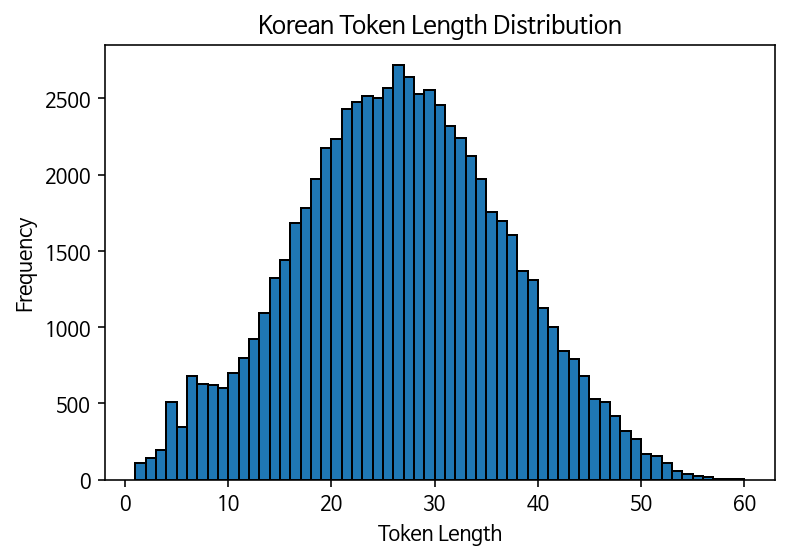

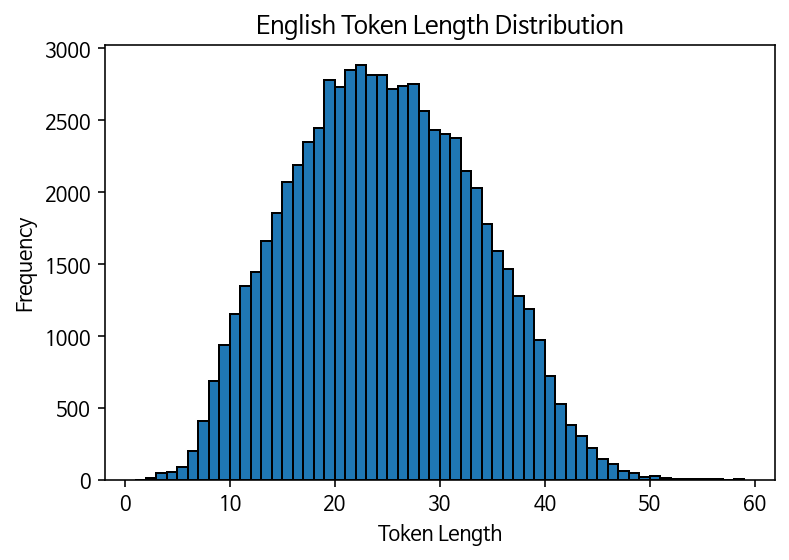

In [22]:
# 한국어 데이터 토큰 길이 분포
token_lengths_kor = [len(sentence.split()) for sentence in tqdm(kor_corpus, desc="Calculating Korean Token Length")]

# 영어 데이터 토큰 길이 분포
token_lengths_eng = [len(sentence.split()) for sentence in tqdm(eng_corpus, desc="Calculating English Token Length")]

# 한국어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_kor, bins=range(1, max(token_lengths_kor) + 1), edgecolor='black')
plt.title("Korean Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# 영어 데이터 토큰 길이 분포 히스토그램
plt.hist(token_lengths_eng, bins=range(1, max(token_lengths_eng) + 1), edgecolor='black')
plt.title("English Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

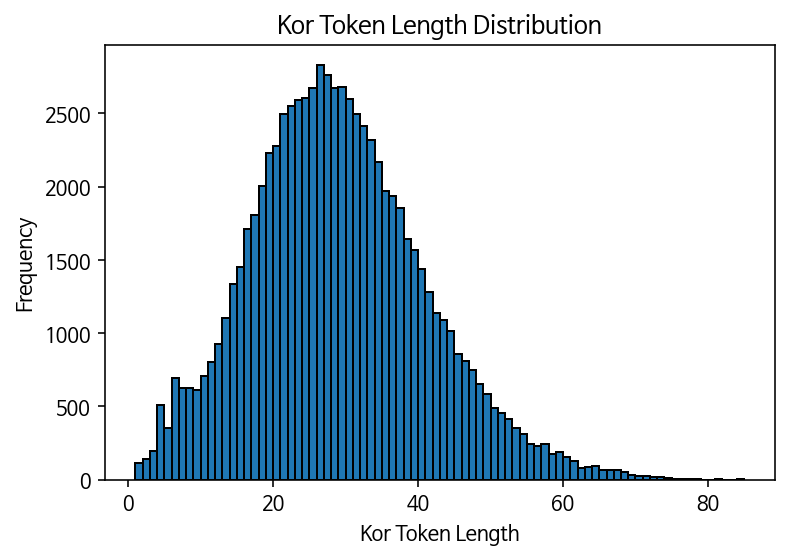

In [61]:
# token_lengths_ko = [len(sentence.split()) for sentence in kor_corpus]

# # 히스토그램 
# plt.hist(token_lengths_ko, bins=range(1, max(token_lengths_ko) + 1), edgecolor='black')
# plt.title("Kor Token Length Distribution")
# plt.xlabel("Kor Token Length")
# plt.ylabel("Frequency")
# plt.show()

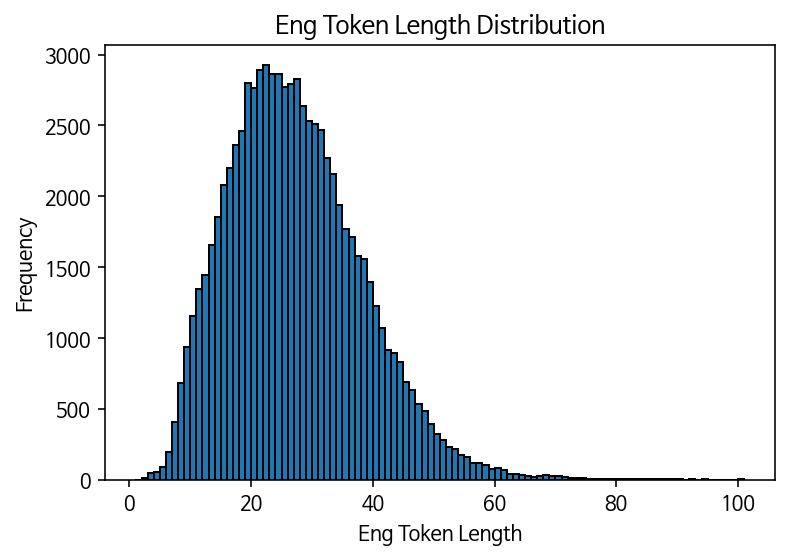

In [62]:
# token_lengths_en = [len(sentence.split()) for sentence in train_en]

# #히스토그램
# plt.hist(token_lengths_en, bins=range(1, max(token_lengths_en) + 1), edgecolor='black')
# plt.title("Eng Token Length Distribution")
# plt.xlabel("Eng Token Length")
# plt.ylabel("Frequency")
# plt.show()

In [23]:
# 한국어(kor_corpus)와 영어(train_en) 데이터 필터링
filtered_kor_corpus = []
filtered_eng_corpus = []
# 
for kor_sent, eng_sent in zip(kor_corpus, eng_corpus):
    if len(kor_sent.split()) <= 45 and len(eng_sent.split()) <= 45: # 결국 절단을 하지 않으면 메모리 부족이 일어난다. 
        filtered_kor_corpus.append(kor_sent)
        filtered_eng_corpus.append(eng_sent)
# 코퍼스 
kor_corpus = filtered_kor_corpus
eng_corpus = filtered_eng_corpus

print(f"Filtered Korean Corpus: {len(kor_corpus)} sentences")
print(f"Filtered English Corpus: {len(eng_corpus)} sentences")

Filtered Korean Corpus: 66477 sentences
Filtered English Corpus: 66477 sentences


In [24]:
# tokenize 함수 정의
def tokenize(corpus, num_words=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

# kor_corpus를 tensor와 tokenizer로 변환
enc_tensor, enc_tokenizer = tokenize(kor_corpus)  # 인코더
dec_tensor, dec_tokenizer = tokenize(eng_corpus)  # 디코더

print("Encoder Tensor :", enc_tensor[:3])
print("Decoder Tensor :", dec_tensor[:3])
print("Tokenizer Word Index Kor:", list(enc_tokenizer.word_index.items())[:10])  
print("Tokenizer Word Index Eng:", list(dec_tokenizer.word_index.items())[:10]) 

Encoder Tensor : [[  101   276   225     7   215     4    59    26  5858 17391    30  1068
   4735     5  2202    42   276   225   172   328    15     7  1431     6
   1288     9  1019    11    12    14     4    19    20   584     2     1
      0     0     0     0     0     0     0     0     0]
 [21113  3077    17   893    17   830     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [   23     4   259   100  1128   706  3182  7211 12002    17  4603    13
   1200    46    28    53  1128     5   243    11    32    63   151    46
     86   116   151   170     6  2134     5  2749    34    97     3    35
     39     2     1     0     0     0     0     0     0]]
Decoder Tensor : [[   3  524   26    8 3699 1719 6937    9 5666   13  493   10  218 1203
    26 4016  149   14 1795   11  379    9    8 1034    6

In [25]:
# validation X
enc_train = enc_tensor
dec_train = dec_tensor

print("Enc Train :", enc_train.shape)
print("Dec Train :", dec_train.shape)

Enc Train : (66477, 45)
Dec Train : (66477, 45)


### val set 삭제 + 단어 글자 단위로 cutting 후 토큰화 

In [31]:
# Bahdanau Attention Class 추가
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [32]:
# Encoder Class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.gru = tf.keras.layers.GRU(
            enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, state = self.gru(x)
        return output, state

In [33]:
# Decoder Class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.gru = tf.keras.layers.GRU(
            dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, h_dec, enc_out):
        x = self.embedding(x)
        x = self.dropout(x)
        context_vec, attn_weights = self.attention(h_dec, enc_out)
        context_vec = tf.expand_dims(context_vec, 1)
        x = tf.concat([context_vec, x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attn_weights

In [34]:
# 인코더 & 디코더 
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1
embedding_dim = 512
units = 1024

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

In [35]:
# 6. 손실 함수와 옵티마이저 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [36]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out, enc_hidden = encoder(src)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
            loss += loss_function(tgt[:, t], predictions)
            dec_input = tf.expand_dims(tgt[:, t], 1)

    batch_loss = loss / int(tgt.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [37]:
EPOCHS = 3
BATCH_SIZE = 64

def create_batches(enc_tensor, dec_tensor, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((enc_tensor, dec_tensor))
    dataset = dataset.shuffle(buffer_size=len(enc_tensor)).batch(batch_size, drop_remainder=True)
    return dataset

train_dataset = create_batches(enc_tensor, dec_tensor, BATCH_SIZE)

for epoch in range(EPOCHS):
    total_loss = 0
    step = 0

    for (batch, (src, tgt)) in enumerate(tqdm(train_dataset, desc=f"Epoch {epoch + 1}")):
        batch_loss = train_step(src, tgt, encoder, decoder, optimizer, dec_tokenizer)
        total_loss += batch_loss
        step += 1

    avg_loss = total_loss / step
    print(f"Epoch {epoch + 1}, Loss: {avg_loss.numpy():.4f}")

Epoch 1: 100%|██████████| 1038/1038 [13:21<00:00,  1.30it/s]


Epoch 1, Loss: 3.1344


Epoch 2: 100%|██████████| 1038/1038 [12:41<00:00,  1.36it/s]


Epoch 2, Loss: 2.7205


Epoch 3: 100%|██████████| 1038/1038 [12:44<00:00,  1.36it/s]

Epoch 3, Loss: 2.5448


In [38]:
# 평가 
def evaluate(sentence, encoder, decoder):
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_tensor.shape[-1], padding='post')
    enc_out, enc_hidden = encoder(inputs)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    result = ''
    attention_matrix = []

    for t in range(dec_tensor.shape[1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_matrix.append(attention_weights.numpy())
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += dec_tokenizer.index_word[predicted_id] + ' '
        if dec_tokenizer.index_word[predicted_id] == '<end>':
            break
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_matrix = np.squeeze(attention_matrix, axis=1)
    return result, sentence, attention_matrix

def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

# 번역 확인
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마는 미국의 대통령입니다 .
Predicted translation: the year . <end> 


/tmp/ipykernel_455/2838390276.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_455/2838390276.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


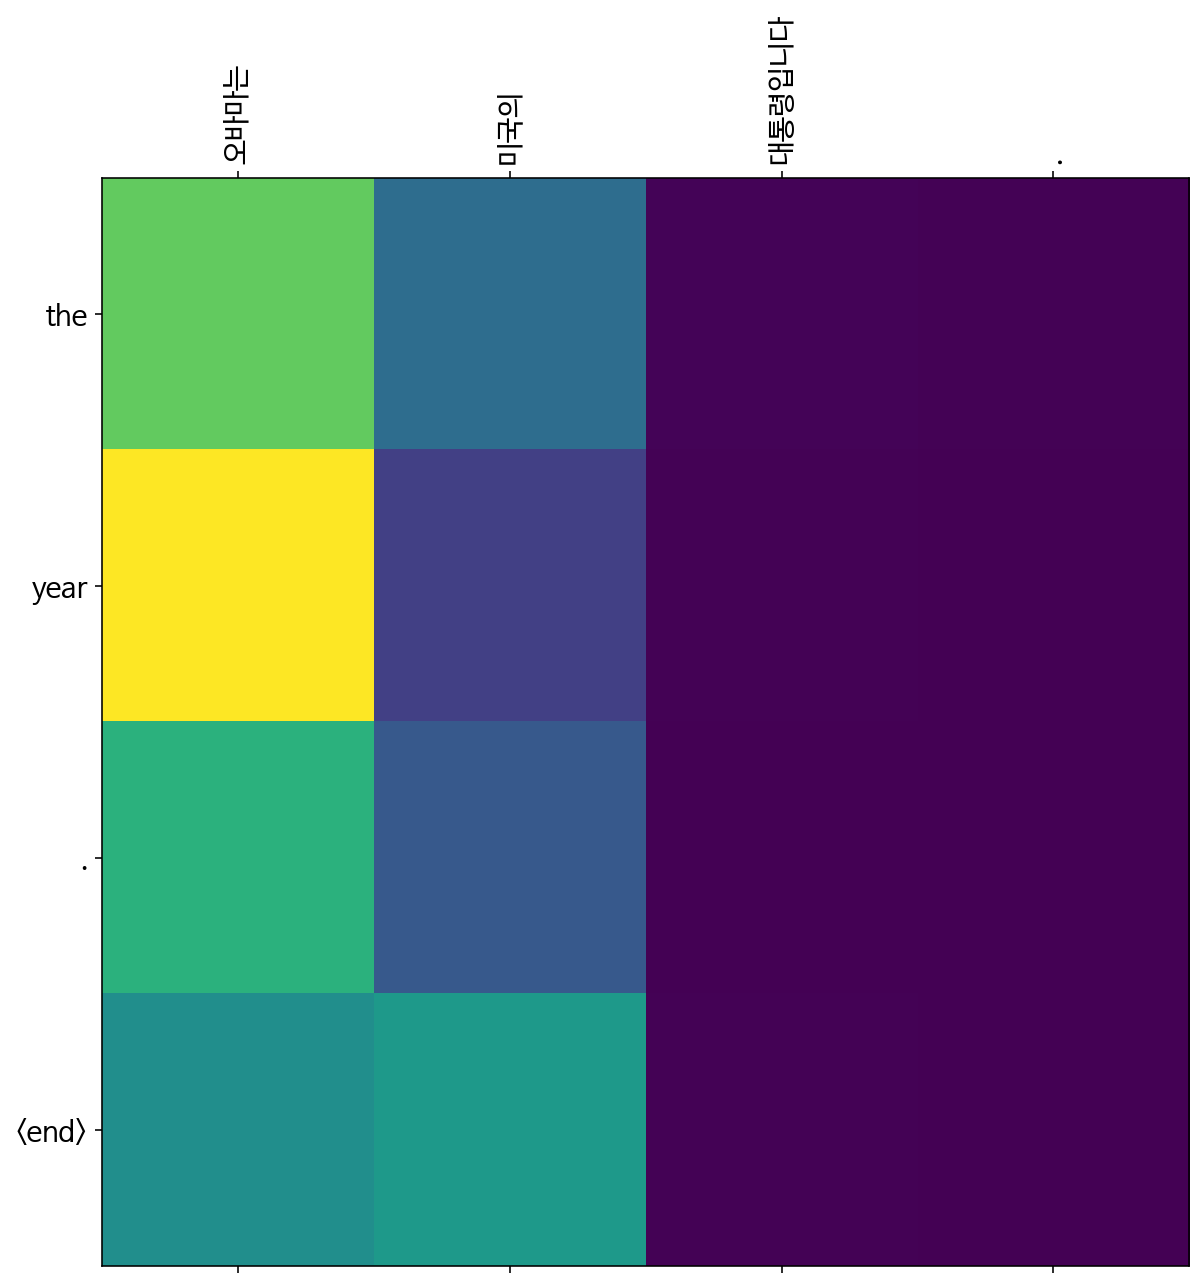

Input: 시민들은 도시 속에 산다 .
Predicted translation: the new york mercantile exchange . <end> 


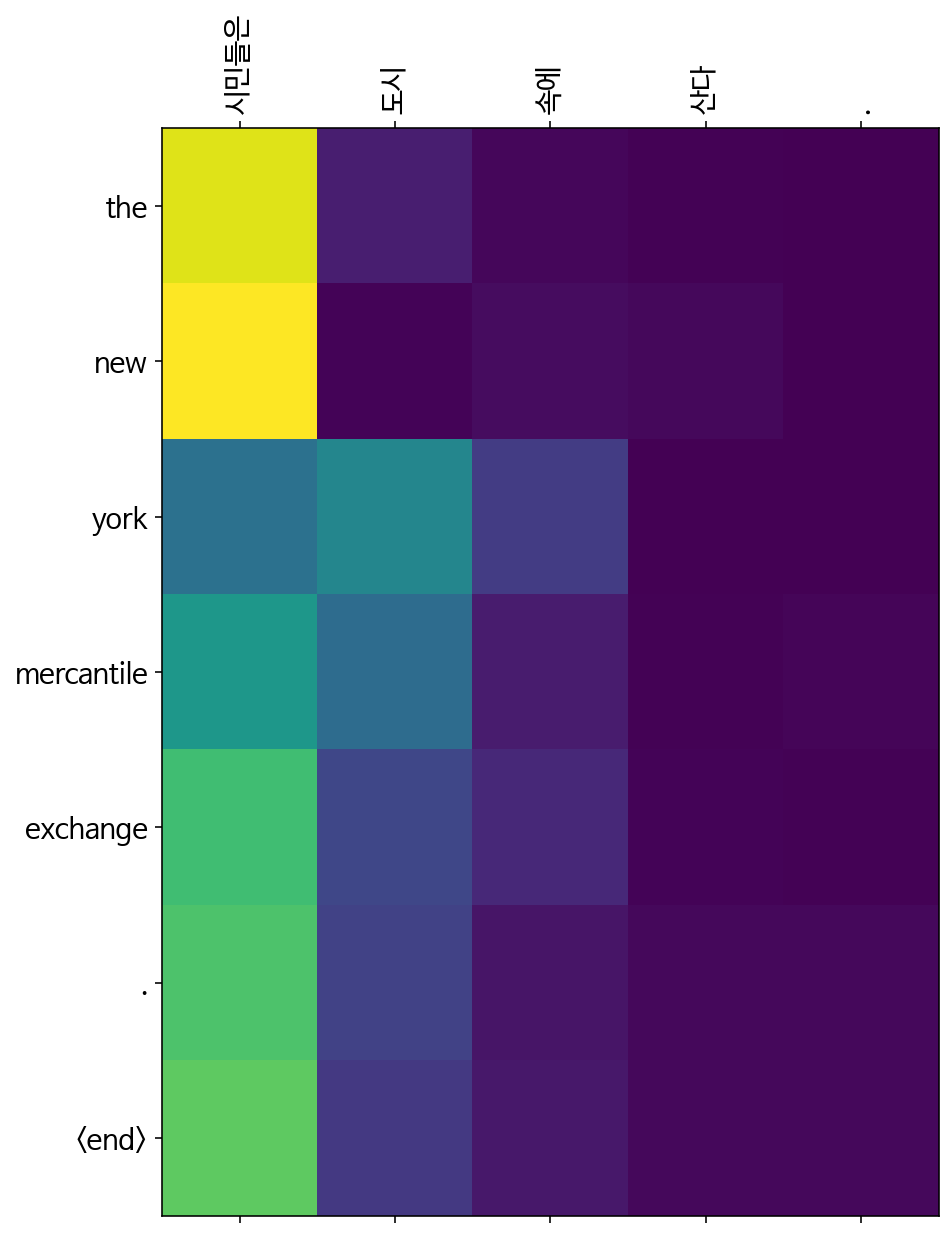

Input: 커피는 필요 없다 .
Predicted translation: the u . s . <end> 


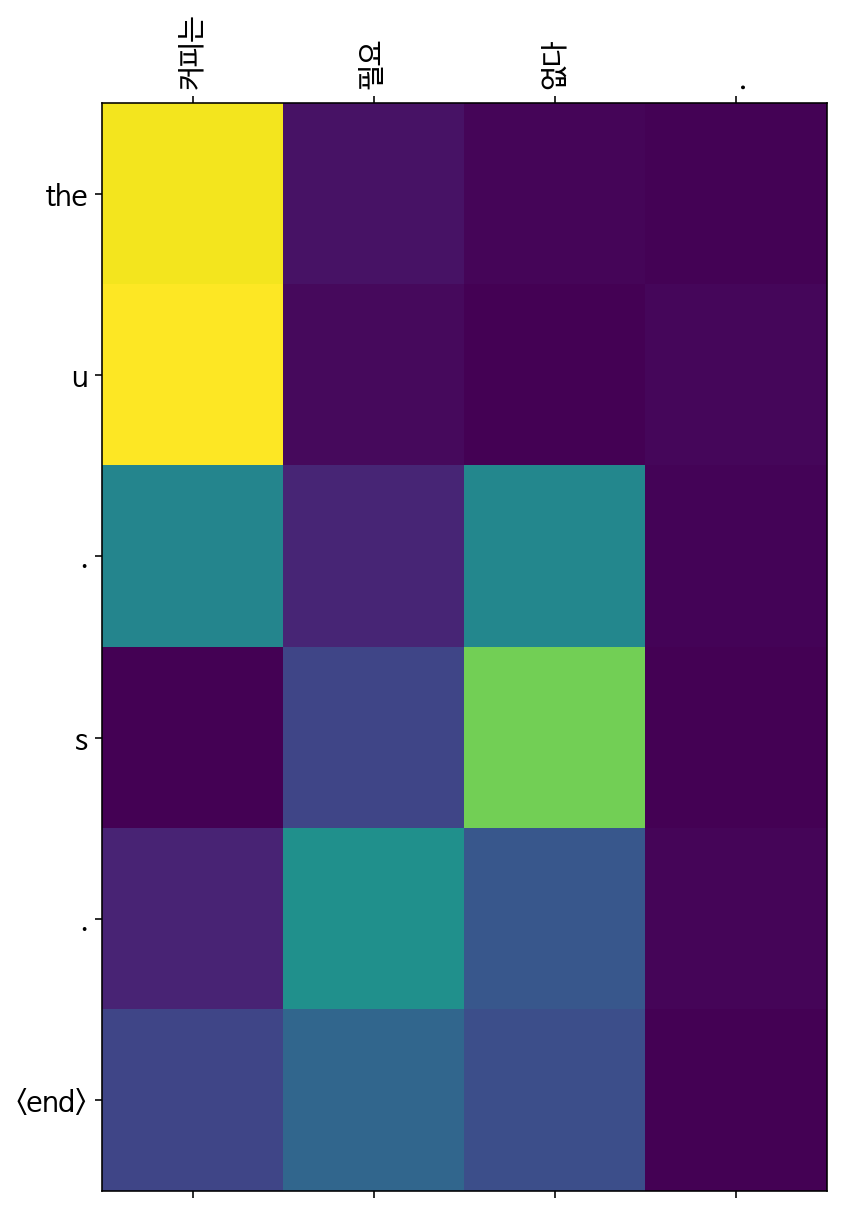

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the year old , the year old , the year old , the year old , the year old , the year old , the year old , the year old , the year old , the year old , the year old , the 


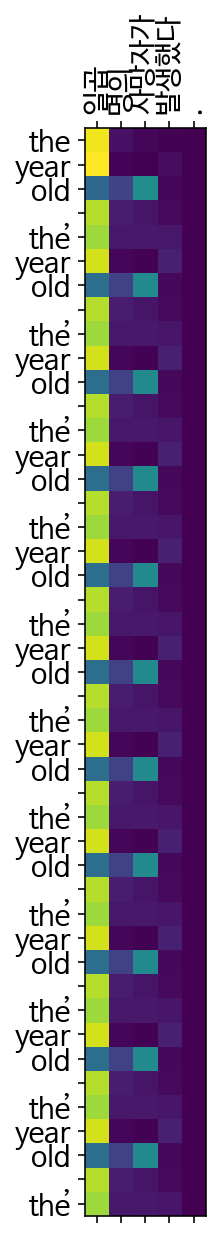

In [39]:
# 오바마는 대통령이다.
# 시민들은 도시 속에 산다.
# 커피는 필요 없다.
# 일곱 명의 사망자가 발생했다.

translate("오바마는 미국의 대통령입니다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### epoch을 늘려서 다시 관찰해봐야할 것 같다.

### val set 이용 + Dropout 적용

In [25]:
# enc_train, enc_test, dec_train, dec_test = train_test_split(
#     enc_tensor, dec_tensor, test_size=0.15, random_state=42
# )

# print("Enc Train :", enc_train.shape)
# print("Enc Test  :", enc_test.shape)
# print("Dec Train :", dec_train.shape)
# print("Dec Test  :", dec_test.shape)

Enc Train : (56505, 45)
Enc Test  : (9972, 45)
Dec Train : (56505, 45)
Dec Test  : (9972, 45)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)         # 디코더 출력에 적용되는 가중치 행렬
        self.w_enc = tf.keras.layers.Dense(units)         # 인코더 출력에 적용된는 가중치 행렬
        self.w_com = tf.keras.layers.Dense(1)             # scala score로 출력하는 행렬

    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)                         # 인코더 단어 벡터 차원 변경
        h_dec = tf.expand_dims(h_dec, 1)                  # [batch, unit] - > [batch, 1, unit]
        h_dec = self.w_dec(h_dec)                         # 디코더 역시 벡터 차원 변경

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))     # 하이퍼볼릭탄젠트 활성화 함수를 활용한 스코어 디코더 상태와 인코더

        attn = tf.nn.softmax(score, axis=1)               # 확률로

        # context vector 가중합 계산
        context_vec = attn * h_enc                        # [batch, length, units]
        context_vec = tf.reduce_sum(context_vec, axis=1)  # [batch, units]

        return context_vec, attn

In [27]:
# 인코더 클래스
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)  # 드롭아웃 추가
        self.gru = tf.keras.layers.GRU(
            enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)  # [batch, length, embedding_dim]
        x = self.dropout(x)    # 드롭아웃 적용
        output, state = self.gru(x)  # output: [batch, length, enc_units], state: [batch, enc_units]
        return output

In [28]:
# 디코더 클래스
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)  # 드롭아웃 추가
        self.gru = tf.keras.layers.GRU(
            dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc = tf.keras.layers.Dense(vocab_size)  # 최종 출력층
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, h_dec, enc_out):
        x = self.embedding(x)  # [batch, 1, embedding_dim]
        x = self.dropout(x)    # 드롭아웃 적용

        # Attention 적용
        context_vec, attn_weights = self.attention(enc_out, h_dec)  # context_vec: [batch, units]
        context_vec = tf.expand_dims(context_vec, 1)  # [batch, 1, units]

        # Context Vector와 현재 Embedding 결합
        x = tf.concat([context_vec, x], axis=-1)  # [batch, 1, embedding_dim + units]

        # GRU를 통해 디코더 상태 업데이트
        output, state = self.gru(x)  # output: [batch, 1, units], state: [batch, units]
        output = tf.reshape(output, (-1, output.shape[2]))  # [batch, units]

        # 최종 출력층 적용
        x = self.fc(output)  # [batch, vocab_size]
        return x, state, attn_weights

In [29]:
# 코드를 실행하세요.

BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 45

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 45, 1024)
Decoder Output: (64, 39722)
Decoder Hidden State: (64, 1024)
Attention: (64, 45, 1)


In [30]:
optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [31]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [32]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]  # 배치 크기
    loss = 0  # 평가 손실 초기화

    # 인코더 출력 계산
    enc_out = encoder(src)
    h_dec = enc_out[:, -1]  # 인코더 마지막 Hidden State 사용

    # 디코더의 초기 입력: <start> 토큰
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    predictions = []
    for t in range(1, tgt.shape[1]):
        # 디코더 예측
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        # 손실 계산
        loss += loss_function(tgt[:, t], pred)

        # 가장 높은 확률의 단어 선택 (Greedy Decoding)
        dec_src = tf.expand_dims(tf.argmax(pred, axis=-1, output_type=tf.int32), 1)
        predictions.append(dec_src)

    # 배치 손실 계산
    batch_loss = (loss / int(tgt.shape[1]))

    # 예측 결과를 하나의 텐서로 결합
    predictions = tf.concat(predictions, axis=1)
    return batch_loss, predictions

In [33]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        # Train Step
        batch_loss = train_step(
            enc_train[idx:idx + BATCH_SIZE],
            dec_train[idx:idx + BATCH_SIZE],
            encoder,
            decoder,
            optimizer,
            dec_tokenizer,
        )

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

    # Evaluation after each epoch
    eval_loss, predictions = eval_step(
        enc_test[:BATCH_SIZE],
        dec_test[:BATCH_SIZE],
        encoder,
        decoder,
        dec_tokenizer,
    )

    print(f"Epoch {epoch + 1} Evaluation Loss: {eval_loss.numpy()}")

Epoch  1: 100%|██████████| 883/883 [11:50<00:00,  1.24it/s, Loss 3.7846]  


Epoch 1 Evaluation Loss: 3.838129997253418


Epoch  2: 100%|██████████| 883/883 [10:33<00:00,  1.39it/s, Loss 3.7674]


Epoch 2 Evaluation Loss: 3.8408002853393555


Epoch  3: 100%|██████████| 883/883 [10:33<00:00,  1.39it/s, Loss 3.7750]


Epoch 3 Evaluation Loss: 3.8371055126190186


Input: 오바마는 미국의 대통령입니다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


/tmp/ipykernel_407/2329402442.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/2329402442.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


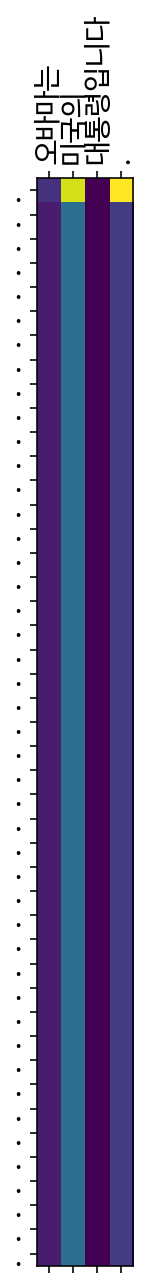

In [34]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오바마는 미국의 대통령입니다.", encoder, decoder)

### 빈도에 따른 중복 문제 or 특수토큰 작동 문제 

### dropout 없을때

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)         # 디코더 출력에 적용되는 가중치 행렬
        self.w_enc = tf.keras.layers.Dense(units)         # 인코더 출력에 적용된는 가중치 행렬
        self.w_com = tf.keras.layers.Dense(1)             # scala score로 출력하는 행렬

    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)                         # 인코더 단어 벡터 차원 변경
        h_dec = tf.expand_dims(h_dec, 1)                  # [batch, unit] - > [batch, 1, unit]
        h_dec = self.w_dec(h_dec)                         # 디코더 역시 벡터 차원 변경

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))     # 하이퍼볼릭탄젠트 활성화 함수를 활용한 스코어 디코더 상태와 인코더

        attn = tf.nn.softmax(score, axis=1)               # 확률로

        # context vector 가중합 계산
        context_vec = attn * h_enc                        # [batch, length, units]
        context_vec = tf.reduce_sum(context_vec, axis=1)  # [batch, units]

        return context_vec, attn

In [25]:
# 인코더 클래스
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)  # [batch, length, embedding_dim]
        output, state = self.gru(x)  # output: [batch, length, enc_units], state: [batch, enc_units]
        return output

In [26]:
# 디코더 클래스
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc = tf.keras.layers.Dense(vocab_size)  # 최종 출력층
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, h_dec, enc_out):
        x = self.embedding(x)  # [batch, 1, embedding_dim]

        # Attention 적용
        context_vec, attn_weights = self.attention(enc_out, h_dec)  # context_vec: [batch, units]
        context_vec = tf.expand_dims(context_vec, 1)  # [batch, 1, units]

        # Context Vector와 현재 Embedding 결합
        x = tf.concat([context_vec, x], axis=-1)  # [batch, 1, embedding_dim + units]

        # GRU를 통해 디코더 상태 업데이트
        output, state = self.gru(x)  # output: [batch, 1, units], state: [batch, units]
        output = tf.reshape(output, (-1, output.shape[2]))  # [batch, units]

        # 최종 출력층 적용
        x = self.fc(output)  # [batch, vocab_size]
        return x, state, attn_weights

In [27]:
# 코드를 실행하세요.

BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 38371)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [29]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [30]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]  # 배치 크기
    loss = 0  # 평가 손실 초기화

    # 인코더 출력 계산
    enc_out = encoder(src)
    h_dec = enc_out[:, -1]  # 인코더 마지막 Hidden State 사용

    # 디코더의 초기 입력: <start> 토큰
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    predictions = []
    for t in range(1, tgt.shape[1]):
        # 디코더 예측
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        # 손실 계산
        loss += loss_function(tgt[:, t], pred)

        # 가장 높은 확률의 단어 선택 (Greedy Decoding)
        dec_src = tf.expand_dims(tf.argmax(pred, axis=-1, output_type=tf.int32), 1)
        predictions.append(dec_src)

    # 배치 손실 계산
    batch_loss = (loss / int(tgt.shape[1]))

    # 예측 결과를 하나의 텐서로 결합
    predictions = tf.concat(predictions, axis=1)
    return batch_loss, predictions

### dropout 추가 안 했을 때 

In [31]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        # Train Step
        batch_loss = train_step(
            enc_train[idx:idx + BATCH_SIZE],
            dec_train[idx:idx + BATCH_SIZE],
            encoder,
            decoder,
            optimizer,
            dec_tokenizer,
        )

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

    # Evaluation after each epoch
    eval_loss, predictions = eval_step(
        enc_test[:BATCH_SIZE],
        dec_test[:BATCH_SIZE],
        encoder,
        decoder,
        dec_tokenizer,
    )

    print(f"Epoch {epoch + 1} Evaluation Loss: {eval_loss.numpy()}")

Epoch  1: 100%|██████████| 785/785 [09:03<00:00,  1.44it/s, Loss 4.0611]


Epoch 1 Evaluation Loss: 4.711524963378906


Epoch  2: 100%|██████████| 785/785 [08:19<00:00,  1.57it/s, Loss 3.2297]


Epoch 2 Evaluation Loss: 5.322824478149414


Epoch  3: 100%|██████████| 785/785 [08:19<00:00,  1.57it/s, Loss 2.8820]


Epoch 3 Evaluation Loss: 5.185506343841553


Epoch  4: 100%|██████████| 785/785 [08:20<00:00,  1.57it/s, Loss 2.5926]


Epoch 4 Evaluation Loss: 5.271111488342285


Epoch  5: 100%|██████████| 785/785 [08:21<00:00,  1.57it/s, Loss 2.3416]


Epoch 5 Evaluation Loss: 5.308541774749756


Epoch  6: 100%|██████████| 785/785 [08:21<00:00,  1.57it/s, Loss 2.1102]


Epoch 6 Evaluation Loss: 5.441524028778076


Epoch  7: 100%|██████████| 785/785 [08:21<00:00,  1.56it/s, Loss 1.8924]


Epoch 7 Evaluation Loss: 5.480435848236084


Epoch  8: 100%|██████████| 785/785 [08:21<00:00,  1.57it/s, Loss 1.6909]


Epoch 8 Evaluation Loss: 5.658038139343262


Epoch  9: 100%|██████████| 785/785 [08:21<00:00,  1.56it/s, Loss 1.5125]


Epoch 9 Evaluation Loss: 5.848934650421143


Epoch 10: 100%|██████████| 785/785 [08:21<00:00,  1.57it/s, Loss 1.3517]


Epoch 10 Evaluation Loss: 5.836268901824951


### val Loss가 안 떨어진다. 규제 문제가 아니라 아예 평가함수 or 다른 문제일수도

Input: 오토 이사는 이번 소송에 대해 특별한 언급을 하지는 않았지만 버지니아 복권협회의 결백을 주장하며 자신들의 입장을 적극 변호했다
Predicted translation: the people of people who have endured lives in the nation s capital <end> 


/tmp/ipykernel_142/3948916940.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_142/3948916940.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


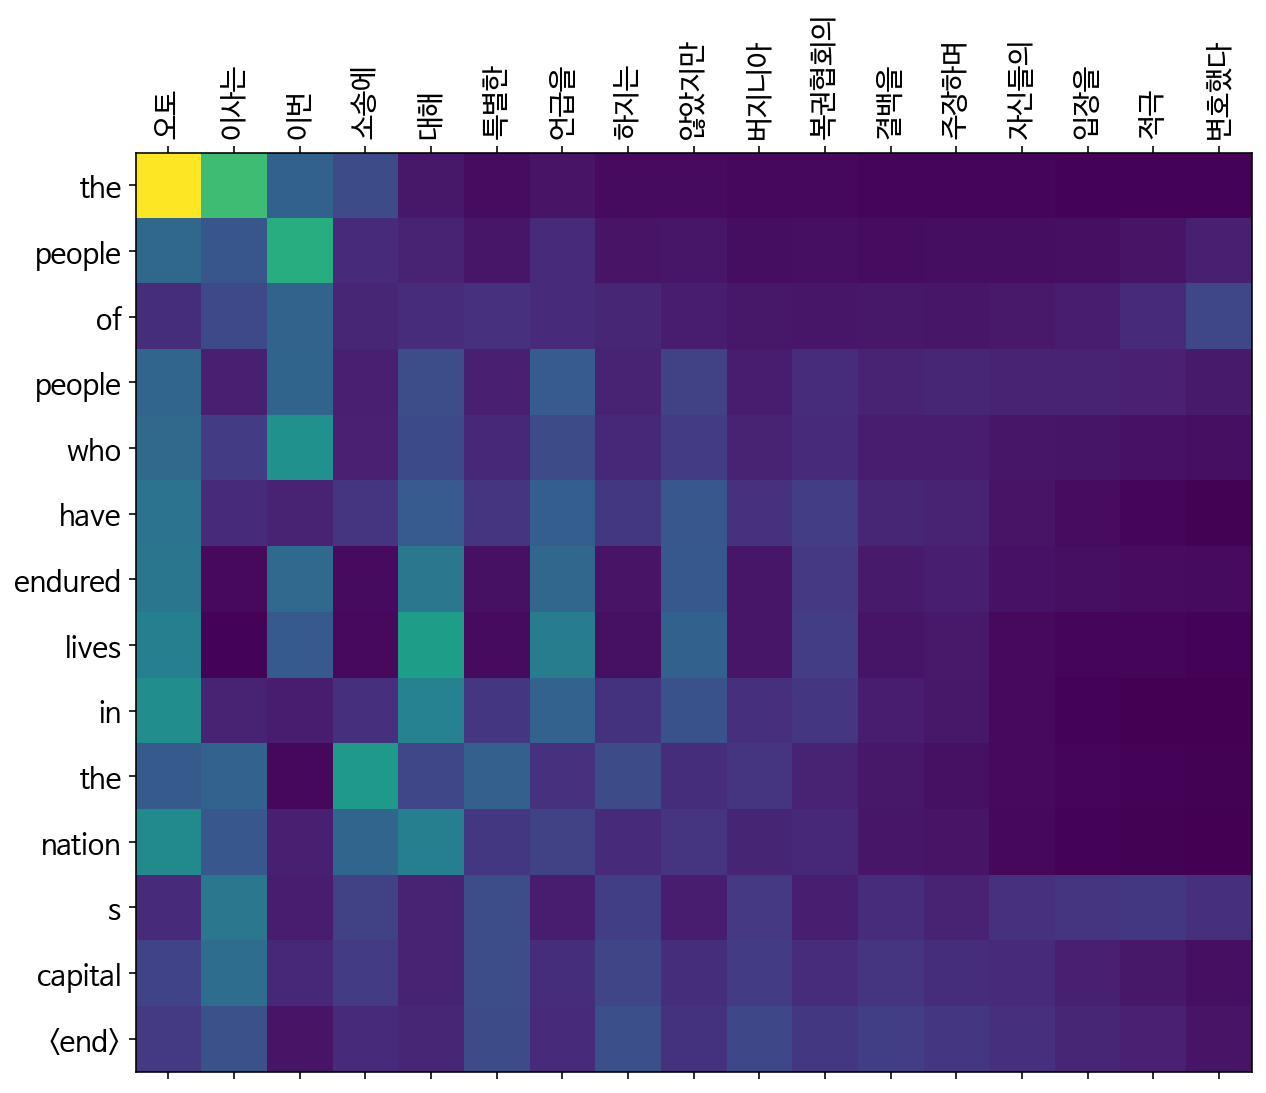

In [35]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

# test_ko
translate("오토 이사는 이번 소송에 대해 특별한 언급을 하지는 않았지만 버지니아 복권협회의 결백을 주장하며 자신들의 입장을 적극 변호했다", encoder, decoder)

### 문장이 너무 길어서 못 잡아내는듯 싶다

### 전체적으로 Validation Loss를 설정했을 때, 떨어지지 않는 문제가 발생한다. 
### 이에 다음과 같은 여러 규제 기법을 추가하면, train,val Loss는 효율적으로 떨어지나 자원 효율이 굉장히 낮아진다.
### 또 결과적으로 빈도에 따른 중복 토큰 문제가 심해진다

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)  # Dropout 
        self.norm = tf.keras.layers.LayerNormalization()
        self.gru = tf.keras.layers.GRU(
            enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
            dropout=0.2,  # Dropout 
        )

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.norm(x)
        output, state = self.gru(x)
        return output


# Decoder 수정
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)  # Dropout 
        self.norm = tf.keras.layers.LayerNormalization()
        self.gru = tf.keras.layers.GRU(
            dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
            dropout=0.2,  # Dropout 
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, h_dec, enc_out):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.norm(x)

        context_vec, attn_weights = self.attention(enc_out, h_dec)
        context_vec = tf.expand_dims(context_vec, 1)
        x = tf.concat([context_vec, x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attn_weights


# 코드를 실행하세요.

BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 50

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)


# 학습률 조정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.002,  # 초기 학습률 증가
    decay_steps=5000, # if batch size = 785*? 5epoch당
    decay_rate=0.98  # 완만한 감소
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)


# Scheduled Sampling을 train_step에 추가
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok, teacher_force_ratio=0.7):  # 초기 의존도 증가
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            loss += loss_function(tgt[:, t], pred)

            if tf.random.uniform([]) < teacher_force_ratio:
                dec_src = tf.expand_dims(tgt[:, t], 1)
            else:
                dec_src = tf.expand_dims(tf.argmax(pred, axis=-1, output_type=tf.int32), 1)

    batch_loss = loss / int(tgt.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss



@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]  # 배치 크기
    loss = 0  # 평가 손실 초기화

    # 인코더 출력 계산
    enc_out = encoder(src)
    h_dec = enc_out[:, -1]  # 인코더 마지막 Hidden State 사용

    # 디코더의 초기 입력: <start> 토큰
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    predictions = []
    for t in range(1, tgt.shape[1]):
        # 디코더 예측
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        # 손실 계산
        loss += loss_function(tgt[:, t], pred)

        # 가장 높은 확률의 단어 선택 (Greedy Decoding)
        dec_src = tf.expand_dims(tf.argmax(pred, axis=-1, output_type=tf.int32), 1)
        predictions.append(dec_src)

    # 배치 손실 계산
    batch_loss = (loss / int(tgt.shape[1]))

    # 예측 결과를 하나의 텐서로 결합
    predictions = tf.concat(predictions, axis=1)
    return batch_loss, predictions


# 최적화
EPOCHS = 10
best_val_loss = np.inf
best_weights = None

for epoch in range(EPOCHS):
    total_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(
            enc_train[idx:idx + BATCH_SIZE],
            dec_train[idx:idx + BATCH_SIZE],
            encoder,
            decoder,
            optimizer,
            dec_tokenizer,
        )

        total_loss += batch_loss
        t.set_description_str(f'Epoch {epoch + 1}')
        t.set_postfix_str(f'Loss {total_loss.numpy() / (batch + 1):.4f}')

    eval_loss, predictions = eval_step(
        enc_test[:BATCH_SIZE],
        dec_test[:BATCH_SIZE],
        encoder,
        decoder,
        dec_tokenizer,
    )

    print(f"Epoch {epoch + 1} Evaluation Loss: {eval_loss.numpy()}")

    if eval_loss.numpy() < best_val_loss:
        best_val_loss = eval_loss.numpy()
        best_weights = {
            "encoder": encoder.get_weights(),
            "decoder": decoder.get_weights(),
        }
        print(f"Best Validation Loss Improved to {best_val_loss:.4f}, Saving Weights")

encoder.set_weights(best_weights["encoder"])
decoder.set_weights(best_weights["decoder"])
print("Loaded Best Weights Based on Validation Loss")